In [2]:
import pandas as pd
import numpy as np

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

### 전처리된 데이터 불러오기

In [4]:
baby_growth_df = pd.read_csv("./baby_growth_df.csv")
baby_growth_df

,days,height,weight,gender
0,0,52.0,3.78,1
1,0,52.0,3.78,1
2,0,50.0,3.20,1
3,1,51.0,2.45,1
4,1,50.0,2.80,1
...,...,...,...,...
79344,365,74.6,9.60,0
79345,365,74.6,8.60,0
79346,365,74.6,9.40,0
79347,365,74.6,9.40,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### height 예측 모델링

In [5]:
# 독립 변수와 종속 변수 분리
X = baby_growth_df[['days','gender']]
y = baby_growth_df['height']

# train/test 데이터 분리, 성별 비중 유지
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=X['gender'], random_state=42)

### (1) LinearRegression - height 예측 모델

In [6]:
# linear regression 모델 학습
lr_height = LinearRegression()
lr_height.fit(X_train, y_train)

# test 데이터로 예측
y_pred = lr_height.predict(X_test)

# 모델 성능 평가
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

# MSE 평가
mse = mean_squared_error(y_test, y_pred)
print("LinearRegression MSE:", mse)

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(lr_height.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(lr_height.score(X_test, y_test)))

R-squared: 0.9053437089619766
LinearRegression MSE: 3.52819616917368
훈련 세트 정확도: 0.905
테스트 세트 정확도: 0.905


### (1-1) 이차항 선형 회귀 - height 예측 모델

In [140]:
# 이차항 생성
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_height = poly.fit_transform(X)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_poly_height, y, test_size=0.25, stratify=X['gender'], random_state=42)

# 모델 학습
lr2_height = LinearRegression()
lr2_height.fit(X_train, y_train)

# 예측
y_pred = lr2_height.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
print("linearRegression2 Mean Squared Error:", mse)

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(lr2_height.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(lr2_height.score(X_test, y_test)))


linearRegression2 Mean Squared Error: 0.6987426294820096
훈련 세트 정확도: 0.981
테스트 세트 정확도: 0.981


### (2) RandomForestRegressor - height 예측 모델

In [7]:
# RandomForestRegressor 모델 객체 생성
rf_height = RandomForestRegressor(random_state=42)

# 모델 학습
rf_height.fit(X_train, y_train)

# 모델 평가 - 예측값 생성
y_pred = rf_height.predict(X_test)

# 모델 평가 - 평균 제곱 오차 계산
mse = mean_squared_error(y_test, y_pred)
print("RandomForestRegressor Mean Squared Error:", mse)

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(rf_height.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(rf_height.score(X_test, y_test)))

RandomForestRegressor Mean Squared Error: 0.25375292488684353
훈련 세트 정확도: 0.993
테스트 세트 정확도: 0.993


### (3) XGBRegressor - height 예측 모델

In [171]:
# 모델 객체 생성
xgb_height = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42)

# 모델 학습
xgb_height.fit(X_train, y_train)

# 검증용 데이터를 사용하여 예측 수행
y_pred = xgb_height.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"xgboost MSE: {mse:.3f}")
print(f"xgboost MAE: {mae:.3f}")
print(f"xgboost R-squared: {r2:.3f}")

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(xgb_height.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(xgb_height.score(X_test, y_test)))

xgboost MSE: 0.316
xgboost MAE: 0.204
xgboost R-squared: 0.992
훈련 세트 정확도: 0.992
테스트 세트 정확도: 0.992


### RandomForestRegressor hyperparameter tuning

In [9]:
# 하이퍼파라미터 후보 값들
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV 수행
rf_height = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_height, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 그 때의 성능 출력
print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score:", -grid_search.best_score_)

# 최적의 하이퍼파라미터로 모델 학습 및 평가
rf_height_best = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'],
                                 max_depth=grid_search.best_params_['max_depth'],
                                 min_samples_split=grid_search.best_params_['min_samples_split'],
                                 random_state=42)
rf_height_best.fit(X_train, y_train)
y_pred_rf = rf_height_best.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_pred_rf))

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(rf_height_best.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(rf_height_best.score(X_test, y_test)))


Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
Best CV score: 0.2536826197356331
Test MSE: 0.2537769441848588
훈련 세트 정확도: 0.993
테스트 세트 정확도: 0.993


### (4) LightGBM - height 예측 모델

In [172]:
# LightGBM 모델링
lgbm_height = LGBMRegressor(random_state=42)
lgbm_height.fit(X_train, y_train)

# 예측값 생성
y_pred = lgbm_height.predict(X_test)

# MSE 평가
mse = mean_squared_error(y_test, y_pred)
print("lightGBM MSE:", mse)

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(lgbm_height.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(lgbm_height.score(X_test, y_test)))

lightGBM MSE: 0.30606518685357387
훈련 세트 정확도: 0.992
테스트 세트 정확도: 0.992


### (5) GradientBoosting - height 예측 모델

In [173]:
# Gradient Boosting 모델 학습
gbr_height = GradientBoostingRegressor(random_state=42)
gbr_height.fit(X_train, y_train)

# 모델 예측
y_pred = gbr_height.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
print("GradientBoostingRegressor MSE:", mse)

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(gbr_height.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbr_height.score(X_test, y_test)))

GradientBoostingRegressor MSE: 0.35741078812332194
훈련 세트 정확도: 0.990
테스트 세트 정확도: 0.990


### Weight 예측 모델링

In [8]:
# 독립 변수와 종속 변수 분리
X_data = baby_growth_df[['days','gender','height']]
y_target = baby_growth_df['weight']

# train/test 데이터 분리, 성별 비중 유지
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.25, stratify=X_data['gender'], random_state=42)

In [146]:
# 이차항 생성
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_weight = poly.fit_transform(X_data)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_poly_weight, y_target, test_size=0.25, stratify=X_data['gender'], random_state=42)

# 모델 학습
lr2_weight = LinearRegression()
lr2_weight.fit(X_train, y_train)

# 예측
y_pred = lr2_weight.predict(X_test)

# 평가
mse = mean_squared_error(y_test, y_pred)
print("linearRegression2 Mean Squared Error:", mse)

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(lr2_weight.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(lr2_weight.score(X_test, y_test)))


linearRegression2 Mean Squared Error: 0.3476746801007111
훈련 세트 정확도: 0.890
테스트 세트 정확도: 0.890


### (1) RandomForestRegressor - weight 예측 모델

In [9]:
# RandomForestRegressor 모델 객체 생성
rf_weight = RandomForestRegressor(random_state=42)

# 모델 학습
rf_weight.fit(X_train, y_train)

# 모델 평가 - 예측값 생성
y_pred = rf_weight.predict(X_test)

# 모델 평가 - 평균 제곱 오차 계산
mse = mean_squared_error(y_test, y_pred)
print("RandomForestRegressor Mean Squared Error:", mse)

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(rf_weight.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(rf_weight.score(X_test, y_test)))

RandomForestRegressor Mean Squared Error: 0.35142692140924253
훈련 세트 정확도: 0.897
테스트 세트 정확도: 0.889


In [47]:
# 하이퍼파라미터 후보 값들
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV 수행
rf_weight = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_weight, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 그 때의 성능 출력
print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score:", -grid_search.best_score_)

# 최적의 하이퍼파라미터로 모델 학습 및 평가
rf_weight_best = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'],
                                 max_depth=grid_search.best_params_['max_depth'],
                                 min_samples_split=grid_search.best_params_['min_samples_split'],
                                 random_state=42)
rf_weight_best.fit(X_train, y_train)
y_pred_rf = rf_weight_best.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_pred_rf))

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(rf_weight_best.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(rf_weight_best.score(X_test, y_test)))


Best hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best CV score: 0.3465750289982933
Test MSE: 0.34468287750259985
훈련 세트 정확도: 0.894
테스트 세트 정확도: 0.891


AttributeError: 'RandomForestRegressor' object has no attribute 'oob_score_'

### (2) LinearRegressor - weight 예측 모델

In [10]:
lr_weight = LinearRegression()

lr_weight.fit(X_train, y_train)
lr_weight.score(X_test, y_test)

print("훈련 세트 정확도: {:.3f}".format(lr_weight.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(lr_weight.score(X_test, y_test)))

훈련 세트 정확도: 0.885
테스트 세트 정확도: 0.885


### (3) GradientBoostingRegressor - weight 예측 모델

In [214]:
gbr_weight = GradientBoostingRegressor()

gbr_weight.fit(X_train, y_train)

# 평가
print("훈련 세트 정확도: {:.3f}".format(gbr_weight.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbr_weight.score(X_test, y_test)))

훈련 세트 정확도: 0.892
테스트 세트 정확도: 0.891


### (4) lightGBM - weight 예측 모델

In [215]:
# LightGBM 모델링
lgbm_weight = LGBMRegressor(random_state=42)
lgbm_weight.fit(X_train, y_train)

# 예측값 생성
y_pred = lgbm_weight.predict(X_test)

# MSE 평가
mse = mean_squared_error(y_test, y_pred)
print("lightGBM MSE:", mse)

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(lgbm_weight.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(lgbm_weight.score(X_test, y_test)))

lightGBM MSE: 0.34462365868841655
훈련 세트 정확도: 0.893
테스트 세트 정확도: 0.891


In [216]:
# 모델 객체 생성
xgb_weight = XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42)

# 모델 학습
xgb_weight.fit(X_train, y_train)

# 검증용 데이터를 사용하여 예측 수행
y_pred = xgb_weight.predict(X_test)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"xgboost MSE: {mse:.3f}")
print(f"xgboost MAE: {mae:.3f}")
print(f"xgboost R-squared: {r2:.3f}")

# 정확도 평가
print("훈련 세트 정확도: {:.3f}".format(xgb_weight.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(xgb_weight.score(X_test, y_test)))

xgboost MSE: 0.346
xgboost MAE: 0.459
xgboost R-squared: 0.891
훈련 세트 정확도: 0.894
테스트 세트 정확도: 0.891


In [27]:
# 사용자로부터 데이터 입력받기
input_days = int(input("생후 일 수를 입력하세요: "))
input_height = float(input("아기의 현재 키를 입력하세요 (단위: cm): "))
input_weight = float(input("아기의 현재 몸무게를 입력하세요 (단위: kg): "))
input_gender = input("아기의 성별을 입력하세요 (F/M): ")

# 입력받은 데이터로 1개월, 3개월, 6개월 뒤의 키 예측
if input_gender == 'F':
    gender = 0
elif input_gender == 'M':
    gender = 1
else:
    print("성별은 'F' 또는 'M' 중에서 입력해주세요.")
    exit()


# polynomial regression
#one_month_pred_height = lr2_height.predict([[(input_days+30)**2, (input_days + 30), gender]])
#three_month_pred_height = lr2_height.predict(np.array([[((input_days+90)**2), (input_days+90), gender]])) 
#six_month_pred_height = lr2_height.predict(np.array([[((input_days+180)**2), (input_days+180), gender]])) 

#one_month_pred_weight = lr2_weight.predict(np.array([[((input_days+30)**2), (input_days+30), gender, one_month_pred_height]]))
#three_month_pred_weight = lr2_weight.predict(np.array([[((input_days+90)**2), (input_days+90), gender, three_month_pred_height]])) 
#six_month_pred_weight = lr2_weight.predict(np.array([[((input_days+180)**2), (input_days+180), gender, six_month_pred_height]])) 
one_month_pred_height = rf_height.predict([[input_days+30, gender]])
three_month_pred_height = rf_height.predict([[input_days+90, gender]])
six_month_pred_height = rf_height.predict([[input_days+180, gender]])

one_month_pred_weight = rf_weight.predict([[input_days+30, gender, one_month_pred_height]])
three_month_pred_weight = rf_weight.predict([[input_days+90, gender, three_month_pred_height]])
six_month_pred_weight = rf_weight.predict([[input_days+180, gender, six_month_pred_height]])


# 결과 출력
print(f"아기의 1개월 뒤 예상 키는 {one_month_pred_height[0]:.1f}cm 입니다.")
print(f"아기의 3개월 뒤 예상 키는 {three_month_pred_height[0]:.1f}cm 입니다.")
print(f"아기의 6개월 뒤 예상 키는 {six_month_pred_height[0]:.1f}cm 입니다.")
print(f"아기의 1개월 뒤 예상 몸무게는 {one_month_pred_weight[0]:.1f}kg 입니다.")
print(f"아기의 3개월 뒤 예상 몸무게는 {three_month_pred_weight[0]:.1f}kg 입니다.")
print(f"아기의 6개월 뒤 예상 몸무게는 {six_month_pred_weight[0]:.1f}kg 입니다.")

아기의 1개월 뒤 예상 키는 74.6cm 입니다.
아기의 3개월 뒤 예상 키는 74.6cm 입니다.
아기의 6개월 뒤 예상 키는 74.6cm 입니다.
아기의 1개월 뒤 예상 몸무게는 9.3kg 입니다.
아기의 3개월 뒤 예상 몸무게는 9.3kg 입니다.
아기의 6개월 뒤 예상 몸무게는 9.3kg 입니다.


In [25]:
# for height graph
graph_height = [input_height] # 0일 뒤 키 == 현재 입력 키
x_height_days = list(range(1,181)) # 1일 뒤부터 180일 뒤 까지
for i in range(1,181):
    graph_height.append(rf_height.predict([[input_days + i, gender]])[0])
graph_height


[66.0,
 67.52143816503512,
 68.0,
 68.30000000000013,
 69.0,
 67.0,
 70.0,
 68.5,
 68.19999999999987,
 69.3614773702143,
 68.5938099303474,
 69.69084002710905,
 69.14999999999989,
 67.1000000000001,
 68.0,
 68.0,
 69.05000000000013,
 68.96732641108888,
 69.5,
 67.64999999999989,
 68.30000000000013,
 70.69999999999987,
 69.64999999999988,
 70.0,
 67.80000000000013,
 70.10000000000012,
 71.0,
 69.5,
 69.0,
 70.0,
 69.0,
 71.75,
 69.0,
 71.0,
 70.0,
 70.92020534173004,
 72.0,
 71.25,
 70.39999999999988,
 70.55000000000013,
 70.94999999999987,
 71.0,
 68.89999999999989,
 72.0,
 72.0,
 71.39999999999988,
 70.01799948744062,
 71.47120022683411,
 70.69999999999987,
 71.4503436548132,
 70.0,
 72.0,
 70.35000000000012,
 70.30000000000013,
 70.60000000000012,
 70.69575528050376,
 71.35436049101484,
 70.89052704378958,
 70.82376096322687,
 70.30000000000013,
 71.0,
 73.5,
 70.0,
 71.40625984570983,
 70.5,
 70.0,
 69.80000000000013,
 71.44926709059335,
 72.39999999999988,
 71.64999999999988,
 71.0

In [26]:
# for weight graph
graph_weight = [input_weight] # 0일 뒤 몸무게 == 현재 입력 몸무게
x_weight_days = list(range(1,181)) # 1일 뒤부터 180일 뒤 까지
for i in range(1,181):
    graph_weight.append(rf_weight.predict([[input_days + i, gender, graph_height[i]]])[0])
graph_weight


[8.0,
 7.715513964368966,
 8.490750914975546,
 9.122112078199578,
 8.492518909090853,
 8.592210015572666,
 7.944971876313113,
 8.261828499439156,
 8.328858633179687,
 8.291073020087074,
 8.246686111111114,
 8.347993491647241,
 8.605356143274792,
 8.267589393857778,
 7.979791869241872,
 8.546455505605508,
 8.611119510201103,
 9.260836346986336,
 8.297625833643485,
 8.559651349610316,
 8.8581133272727,
 7.94903957184972,
 8.283676805041367,
 8.571805416920299,
 8.88096824703075,
 8.607352941898013,
 8.682923724378526,
 9.076615408692616,
 8.560488636363637,
 8.386224691554697,
 8.971752877024937,
 8.736134350567735,
 8.916292813611394,
 8.478864110889111,
 8.630282078893332,
 9.015646370296373,
 8.423939413352684,
 8.547837443776126,
 8.935508377044393,
 8.449649515231501,
 8.633628387927432,
 8.513608353342564,
 8.954861244511614,
 8.96805168456936,
 8.687841066539328,
 8.514040270103562,
 8.710126935343204,
 8.679331868297423,
 8.830244632764467,
 8.903256324065081,
 8.296476725525098,

### 단순선형회귀 - 선택

In [94]:
# 현재 생후 일 수
current_days = int(input("현재 생후 일 수를 입력하세요: "))

# 현재 키, 몸무게, 성별 입력
current_height = float(input("현재 키를 입력하세요: "))
current_weight = float(input("현재 몸무게를 입력하세요: "))
input_gender = input("아기의 성별을 입력하세요 (M/F): ")

if input_gender == 'F':
    gender = 0
elif input_gender == 'M':
    gender = 1
else:
    print("성별은 'F' 또는 'M' 중에서 입력해주세요.")
    exit()
# 해당 성별에 해당하는 데이터 필터링
filtered_df = baby_growth_df[baby_growth_df['gender'] == gender]

# 키에 대한 예측 모델 학습
height_X = filtered_df['days'].values.reshape(-1, 1)
height_y = filtered_df['height'].values

# 데이터 분할
# height_X_train, height_X_test, height_y_train, height_y_test = train_test_split(height_X, height_y, test_size=0.2, random_state=42)

height_model = LinearRegression()
height_model.fit(height_X, height_y)

# 몸무게에 대한 예측 모델 학습
weight_X = filtered_df['days'].values.reshape(-1, 1)
weight_y = filtered_df['weight'].values

# 데이터 분할
# weight_X_train, weight_X_test, weight_y_train, weight_y_test = train_test_split(weight_X, weight_y, test_size=0.2, random_state=42)

weight_model = LinearRegression()
weight_model.fit(weight_X, weight_y)

LinearRegression()

In [95]:
# 예측에 사용할 일 수 범위
prediction_range = range(1, 181)

predicted_heights = []

# 입력한 일 수에 대한 예측값 계산
predicted_height = height_model.predict([[current_days]])
print("current height = ", current_height)
print("predicted_height = ", predicted_height)

if current_height > predicted_height:
    slope_height = height_model.coef_[0]
    print("slope_height = ", slope_height)
    for days in prediction_range:
        prediction_days = current_days + days
        predicted_height_sync = slope_height * prediction_days + (height_model.intercept_ + (current_height - predicted_height))
        predicted_heights.append(predicted_height_sync)
else:
    slope_height = height_model.coef_[0]
    for days in prediction_range:
        prediction_days = current_days + days
        predicted_height_sync = slope_height * prediction_days + (height_model.intercept_ - (predicted_height - current_height))
        predicted_heights.append(predicted_height_sync)

predicted_heights

current height =  72.0
predicted_height =  [66.09668543]
slope_height =  0.08434232981542161


[array([72.08434233]),
 array([72.16868466]),
 array([72.25302699]),
 array([72.33736932]),
 array([72.42171165]),
 array([72.50605398]),
 array([72.59039631]),
 array([72.67473864]),
 array([72.75908097]),
 array([72.8434233]),
 array([72.92776563]),
 array([73.01210796]),
 array([73.09645029]),
 array([73.18079262]),
 array([73.26513495]),
 array([73.34947728]),
 array([73.43381961]),
 array([73.51816194]),
 array([73.60250427]),
 array([73.6868466]),
 array([73.77118893]),
 array([73.85553126]),
 array([73.93987359]),
 array([74.02421592]),
 array([74.10855825]),
 array([74.19290058]),
 array([74.27724291]),
 array([74.36158523]),
 array([74.44592756]),
 array([74.53026989]),
 array([74.61461222]),
 array([74.69895455]),
 array([74.78329688]),
 array([74.86763921]),
 array([74.95198154]),
 array([75.03632387]),
 array([75.1206662]),
 array([75.20500853]),
 array([75.28935086]),
 array([75.37369319]),
 array([75.45803552]),
 array([75.54237785]),
 array([75.62672018]),
 array([75.711

In [91]:
slope = height_model.coef_[0]
intercept = height_model.intercept_

print("회귀식: y = {}x + {}".format(slope, intercept))

회귀식: y = 0.08092495401469552x + 52.16795255578642


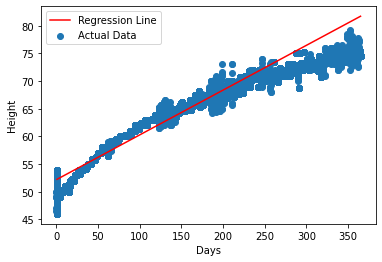

In [45]:
import matplotlib.pyplot as plt

# 예측할 범위 설정
prediction_range = range(1, 366)

# 예측 결과 계산
predicted_heights = [slope * x + intercept for x in prediction_range]

# 데이터 포인트 그래프로 표시
plt.scatter(height_X, height_y, label='Actual Data')

# 회귀식 그래프로 표시
plt.plot(prediction_range, predicted_heights, color='red', label='Regression Line')

# 축 레이블 설정
plt.xlabel('Days')
plt.ylabel('Height')

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()

In [96]:
# 예측에 사용할 일 수 범위
prediction_range = range(1, 181)

# 예측 결과를 저장할 리스트 초기화
predicted_weights = []

# 입력한 일 수에 대한 예측값 계산
predicted_weight = weight_model.predict([[current_days]])
print("current weight = ", current_weight)
print("predicted_weight = ", predicted_weight)


if current_weight > predicted_weight:
    slope_weight = weight_model.coef_[0]
    print("slope_weight = ", slope_weight)
    for days in prediction_range:
        prediction_days = current_days + days
        predicted_weight_sync = slope_weight * prediction_days + (weight_model.intercept_ + (current_weight - predicted_weight))
        predicted_weights.append(predicted_weight_sync)
else:
    slope_weight = weight_model.coef_[0]
    print("slope_weight = ", slope_weight)
    for days in prediction_range:
        prediction_days = current_days + days
        predicted_weight_sync = slope_weight * prediction_days + (weight_model.intercept_ - (predicted_weight - current_weight))
        predicted_weights.append(predicted_weight_sync)
        
predicted_weights

current weight =  7.5
predicted_weight =  [7.69398139]
slope_weight =  0.023312481659303996


[array([7.52331248]),
 array([7.54662496]),
 array([7.56993744]),
 array([7.59324993]),
 array([7.61656241]),
 array([7.63987489]),
 array([7.66318737]),
 array([7.68649985]),
 array([7.70981233]),
 array([7.73312482]),
 array([7.7564373]),
 array([7.77974978]),
 array([7.80306226]),
 array([7.82637474]),
 array([7.84968722]),
 array([7.87299971]),
 array([7.89631219]),
 array([7.91962467]),
 array([7.94293715]),
 array([7.96624963]),
 array([7.98956211]),
 array([8.0128746]),
 array([8.03618708]),
 array([8.05949956]),
 array([8.08281204]),
 array([8.10612452]),
 array([8.129437]),
 array([8.15274949]),
 array([8.17606197]),
 array([8.19937445]),
 array([8.22268693]),
 array([8.24599941]),
 array([8.26931189]),
 array([8.29262438]),
 array([8.31593686]),
 array([8.33924934]),
 array([8.36256182]),
 array([8.3858743]),
 array([8.40918678]),
 array([8.43249927]),
 array([8.45581175]),
 array([8.47912423]),
 array([8.50243671]),
 array([8.52574919]),
 array([8.54906167]),
 array([8.57237

In [82]:
slope = weight_model.coef_[0]
intercept = weight_model.intercept_

print("회귀식: y = {}x + {}".format(slope, intercept))

회귀식: y = 0.023312481659303996x + 4.19710914305598


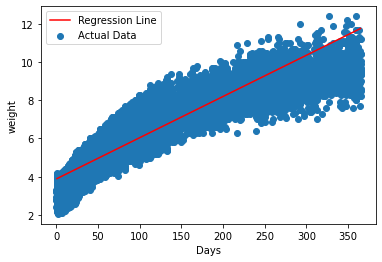

In [62]:
import matplotlib.pyplot as plt

# 예측할 범위 설정
prediction_range = range(1, 366)

# 예측 결과 계산
predicted_weights = [slope * x + intercept for x in prediction_range]

# 데이터 포인트 그래프로 표시
plt.scatter(weight_X, weight_y, label='Actual Data')

# 회귀식 그래프로 표시
plt.plot(prediction_range, predicted_weights, color='red', label='Regression Line')

# 축 레이블 설정
plt.xlabel('Days')
plt.ylabel('weight')

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()

In [97]:
# 결과 출력
print(f"아기의 1개월 뒤 예상 키는 {predicted_heights[29][0]:.1f}cm 입니다.")
print(f"아기의 3개월 뒤 예상 키는 {predicted_heights[89][0]:.1f}cm 입니다.")
print(f"아기의 6개월 뒤 예상 키는 {predicted_heights[179][0]:.1f}cm 입니다.")
print(f"아기의 1개월 뒤 예상 몸무게는 {predicted_weights[29][0]:.1f}kg 입니다.")
print(f"아기의 3개월 뒤 예상 몸무게는 {predicted_weights[89][0]:.1f}kg 입니다.")
print(f"아기의 6개월 뒤 예상 몸무게는 {predicted_weights[179][0]:.1f}kg 입니다.")

아기의 1개월 뒤 예상 키는 74.5cm 입니다.
아기의 3개월 뒤 예상 키는 79.6cm 입니다.
아기의 6개월 뒤 예상 키는 87.2cm 입니다.
아기의 1개월 뒤 예상 몸무게는 8.2kg 입니다.
아기의 3개월 뒤 예상 몸무게는 9.6kg 입니다.
아기의 6개월 뒤 예상 몸무게는 11.7kg 입니다.


### 다항 회귀 

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# 현재 입력 값
current_days = int(input("현재 생후 일 수를 입력하세요: "))
current_height = float(input("현재 키를 입력하세요: "))
current_weight = float(input("현재 몸무게를 입력하세요: "))
input_gender = input("아기의 성별을 입력하세요 (M/F): ")

if input_gender == 'F':
    gender = 0
elif input_gender == 'M':
    gender = 1
else:
    print("성별은 'F' 또는 'M' 중에서 입력해주세요.")
    exit()

# 예측에 사용할 일 수 범위
prediction_range = range(1, 181)
# 다항 회귀 모델 학습을 위한 데이터 준비
filtered_df = baby_growth_df[baby_growth_df['gender'] == gender]

X = filtered_df['days'].values.reshape(-1, 1)
y_height = filtered_df['height'].values
y_weight = filtered_df['weight'].values

# 다항 회귀 모델 학습
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)

height_poly = LinearRegression()
height_poly.fit(X_poly, y_height)

weight_poly = LinearRegression()
weight_poly.fit(X_poly, y_weight)

# 현재 입력 일 수에 대한 예측값 계산
current_days_poly = poly_features.transform([[current_days]])
predicted_height_poly = height_poly.predict(current_days_poly)
print("current height =", current_height)
print("predicted height =", predicted_height_poly)

# 예측 결과를 저장할 리스트 초기화
predicted_heights_poly = []

if current_height > predicted_height_poly:
    c_h = height_poly.intercept_
    b_h = height_poly.coef_[1]
    a_h = height_poly.coef_[2]
    for days in prediction_range:
        prediction_days = current_days + days
        predicted_height_sync = c_h + (current_height - predicted_height_poly) + b_h * prediction_days + a_h * prediction_days**2
        predicted_heights_poly.append(predicted_height_sync)
else:
    c_h = height_poly.intercept_
    b_h = height_poly.coef_[1]
    a_h = height_poly.coef_[2]
    for days in prediction_range:
        prediction_days = current_days + days
        predicted_height_sync = c_h - (predicted_height_poly - current_height) + b_h * prediction_days + a_h * prediction_days**2
        predicted_heights_poly.append(predicted_height_sync)

predicted_heights_poly

current height = 65.0
predicted height = [68.008214]


[array([65.08055379]),
 array([65.16064831]),
 array([65.24028356]),
 array([65.31945955]),
 array([65.39817626]),
 array([65.47643371]),
 array([65.5542319]),
 array([65.63157081]),
 array([65.70845046]),
 array([65.78487084]),
 array([65.86083195]),
 array([65.93633379]),
 array([66.01137637]),
 array([66.08595967]),
 array([66.16008371]),
 array([66.23374849]),
 array([66.30695399]),
 array([66.37970023]),
 array([66.4519872]),
 array([66.5238149]),
 array([66.59518333]),
 array([66.6660925]),
 array([66.7365424]),
 array([66.80653303]),
 array([66.87606439]),
 array([66.94513648]),
 array([67.01374931]),
 array([67.08190287]),
 array([67.14959716]),
 array([67.21683219]),
 array([67.28360794]),
 array([67.34992443]),
 array([67.41578165]),
 array([67.48117961]),
 array([67.54611829]),
 array([67.61059771]),
 array([67.67461786]),
 array([67.73817874]),
 array([67.80128036]),
 array([67.8639227]),
 array([67.92610578]),
 array([67.98782959]),
 array([68.04909414]),
 array([68.109899

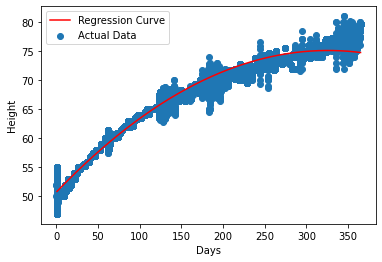

In [11]:
import matplotlib.pyplot as plt

# 예측할 범위 설정
prediction_range = np.arange(1, 366)

# 예측 결과 계산
predicted_heights = height_poly.predict(poly_features.fit_transform(prediction_range.reshape(-1, 1)))

# 데이터 포인트 그래프로 표시
plt.scatter(X, y_height, label='Actual Data')

# 회귀식 그래프로 표시
plt.plot(prediction_range, predicted_heights, color='red', label='Regression Curve')

# 축 레이블 설정
plt.xlabel('Days')
plt.ylabel('Height')

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()

In [12]:
# height 다항 회귀식
print("회귀식: y = {}x^2 + {}x + {}".format(a_h, b_h, c_h))

회귀식: y = -0.0002296338663635422x^2 + 0.14967358211998244x + 50.723938670700164


In [13]:
# 현재 입력 일 수에 대한 예측값 계산
predicted_weight_poly = weight_poly.predict(current_days_poly)
print("current weight =", current_weight)
print("predicted weight =", predicted_weight_poly)

# 예측 결과를 저장할 리스트 초기화
predicted_weights_poly = []

if current_weight > predicted_weight_poly:
    c_w = weight_poly.intercept_
    b_w = weight_poly.coef_[1]
    a_w = weight_poly.coef_[2]
    for days in prediction_range:
        prediction_days = current_days + days
        predicted_weight_sync = c_w + (current_weight - predicted_weight_poly) + b_w * prediction_days + a_w * prediction_days**2
        predicted_weights_poly.append(predicted_weight_sync)
else:
    c_w = weight_poly.intercept_
    b_w = weight_poly.coef_[1]
    a_w = weight_poly.coef_[2]
    for days in prediction_range:
        prediction_days = current_days + days
        predicted_weight_sync = c_w - (predicted_weight_poly - current_weight) + b_w * prediction_days + a_w * prediction_days**2
        predicted_weights_poly.append(predicted_weight_sync)

predicted_weights_poly

current weight = 9.0
predicted weight = [8.29235589]


[array([9.02212654]),
 array([9.04410931]),
 array([9.06594831]),
 array([9.08764355]),
 array([9.10919502]),
 array([9.13060272]),
 array([9.15186666]),
 array([9.17298683]),
 array([9.19396324]),
 array([9.21479587]),
 array([9.23548474]),
 array([9.25602985]),
 array([9.27643118]),
 array([9.29668875]),
 array([9.31680256]),
 array([9.3367726]),
 array([9.35659887]),
 array([9.37628137]),
 array([9.39582011]),
 array([9.41521508]),
 array([9.43446628]),
 array([9.45357372]),
 array([9.47253739]),
 array([9.49135729]),
 array([9.51003343]),
 array([9.5285658]),
 array([9.5469544]),
 array([9.56519924]),
 array([9.58330031]),
 array([9.60125762]),
 array([9.61907115]),
 array([9.63674092]),
 array([9.65426693]),
 array([9.67164916]),
 array([9.68888764]),
 array([9.70598234]),
 array([9.72293328]),
 array([9.73974045]),
 array([9.75640385]),
 array([9.77292349]),
 array([9.78929936]),
 array([9.80553146]),
 array([9.8216198]),
 array([9.83756437]),
 array([9.85336517]),
 array([9.8690

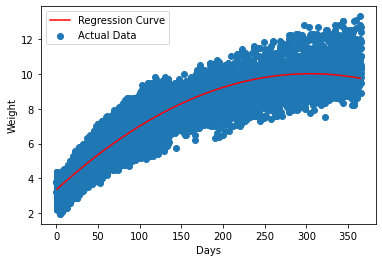

In [14]:
# 예측할 범위 설정
prediction_range = np.arange(1, 366)

# 예측 결과 계산
predicted_weights = weight_poly.predict(poly_features.fit_transform(prediction_range.reshape(-1, 1)))

# 데이터 포인트 그래프로 표시
plt.scatter(X, y_weight, label='Actual Data')

# 회귀식 그래프로 표시
plt.plot(prediction_range, predicted_weights, color='red', label='Regression Curve')

# 축 레이블 설정
plt.xlabel('Days')
plt.ylabel('Weight')

# 범례 표시
plt.legend()

# 그래프 출력
plt.show()

In [15]:
# weight 다항 회귀식
print("회귀식: y = {}x^2 + {}x + {}".format(a_w, b_w, c_w))

회귀식: y = -7.188333530464473e-05x^2 + 0.04376342119035104x + 3.345217751308054


In [16]:
# 결과 출력
print(f"아기의 1개월 뒤 예상 키는 {predicted_heights_poly[29][0]:.1f}cm 입니다.")
print(f"아기의 3개월 뒤 예상 키는 {predicted_heights_poly[89][0]:.1f}cm 입니다.")
print(f"아기의 6개월 뒤 예상 키는 {predicted_heights_poly[179][0]:.1f}cm 입니다.")
print(f"아기의 1개월 뒤 예상 몸무게는 {predicted_weights_poly[29][0]:.1f}kg 입니다.")
print(f"아기의 3개월 뒤 예상 몸무게는 {predicted_weights_poly[89][0]:.1f}kg 입니다.")
print(f"아기의 6개월 뒤 예상 몸무게는 {predicted_weights_poly[179][0]:.1f}kg 입니다.")

아기의 1개월 뒤 예상 키는 67.2cm 입니다.
아기의 3개월 뒤 예상 키는 70.4cm 입니다.
아기의 6개월 뒤 예상 키는 72.1cm 입니다.
아기의 1개월 뒤 예상 몸무게는 9.6kg 입니다.
아기의 3개월 뒤 예상 몸무게는 10.4kg 입니다.
아기의 6개월 뒤 예상 몸무게는 10.7kg 입니다.


### 차분 - 실패

In [28]:
data = baby_growth_df[['days', 'gender', 'height', 'weight']]

# 차분을 적용합니다.
data_diff = data.diff().dropna()

# 입력 변수와 예측 변수를 분할합니다.
X = data_diff[['days', 'gender']]
y_height = data_diff['height']
y_weight = data_diff['weight']

# 훈련 세트와 테스트 세트로 데이터를 분할합니다.
X_train, X_test, y_height_train, y_height_test, y_weight_train, y_weight_test = train_test_split(X, y_height, y_weight, test_size=0.2, random_state=42)

# Linear Regression 모델을 생성하고 훈련합니다.
model_height = LinearRegression()
model_height.fit(X_train, y_height_train)

model_weight = LinearRegression()
model_weight.fit(X_train, y_weight_train)

# 테스트 세트에서의 예측 정확도를 계산합니다.
height_accuracy = model_height.score(X_test, y_height_test)
weight_accuracy = model_weight.score(X_test, y_weight_test)

# 결과 출력
print("Height Accuracy:", height_accuracy)
print("Weight Accuracy:", weight_accuracy)

Height Accuracy: 0.0003925242203888235
Weight Accuracy: 5.264799306492485e-05


In [36]:
# 사용자 입력 값
input_days = int(input("생후 일 수를 입력하세요: "))
input_gender = input("성별을 입력하세요 (Male 또는 Female): ")
input_height = float(input("현재 키를 입력하세요 (cm): "))
input_weight = float(input("현재 몸무게를 입력하세요 (kg): "))

# 입력받은 문자열 성별 변환
if input_gender == 'F':
    input_gender = 0
elif input_gender == 'M':
    input_gender = 1
else:
    print("성별은 'F' 또는 'M' 중에서 입력해주세요.")
    exit()

# 키와 몸무게 예측을 위한 입력 데이터
input_data_height = [[input_days, input_gender]]
input_data_weight = [[input_days, input_gender]]

# 1일부터 180일까지의 키 예측
predictions_height = [input_height]  # 초기값으로 현재 키를 사용
for day in range(1, 181):
    prediction_height_diff = model_height.predict(input_data_height)  # 차분된 예측값
    new_height = predictions_height[day-1] + prediction_height_diff[0]  # 이전 예측값에 차분된 예측값을 더하여 키 예측
    predictions_height.append(new_height)  # 예측값을 리스트에 추가

# 1일부터 180일까지의 몸무게 예측
predictions_weight = [input_weight]  # 초기값으로 현재 몸무게를 사용
for day in range(1, 181):
    prediction_weight_diff = model_weight.predict(input_data_weight)  # 차분된 예측값
    new_weight = predictions_weight[day-1] + prediction_weight_diff[0]  # 이전 예측값에 차분된 예측값을 더하여 몸무게 예측
    predictions_weight.append(new_weight)  # 예측값을 리스트에 추가

# 결과 출력
for day, height, weight in zip(range(1, 181), predictions_height, predictions_weight):
    print("Day:", day)
    print("Predicted Height:", height)
    print("Predicted Weight:", weight)
    print("---")

Day: 1
Predicted Height: 66.0
Predicted Weight: 8.0
---
Day: 2
Predicted Height: 77.5229571818082
Predicted Weight: 18.013365935037267
---
Day: 3
Predicted Height: 89.04591436361639
Predicted Weight: 28.026731870074535
---
Day: 4
Predicted Height: 100.56887154542459
Predicted Weight: 38.0400978051118
---
Day: 5
Predicted Height: 112.09182872723278
Predicted Weight: 48.05346374014907
---
Day: 6
Predicted Height: 123.61478590904098
Predicted Weight: 58.06682967518634
---
Day: 7
Predicted Height: 135.13774309084917
Predicted Weight: 68.08019561022361
---
Day: 8
Predicted Height: 146.66070027265738
Predicted Weight: 78.09356154526088
---
Day: 9
Predicted Height: 158.18365745446556
Predicted Weight: 88.10692748029815
---
Day: 10
Predicted Height: 169.70661463627374
Predicted Weight: 98.12029341533542
---
Day: 11
Predicted Height: 181.22957181808192
Predicted Weight: 108.1336593503727
---
Day: 12
Predicted Height: 192.7525289998901
Predicted Weight: 118.14702528540997
---
Day: 13
Predicted H